[*********************100%***********************]  1 of 1 completed


Epoch 1: Train MSE=0.0817, Val MSE=0.0405
Epoch 2: Train MSE=0.0307, Val MSE=0.0227
Epoch 3: Train MSE=0.0235, Val MSE=0.0232
Epoch 4: Train MSE=0.0227, Val MSE=0.0222
Epoch 5: Train MSE=0.0225, Val MSE=0.0236
Epoch 6: Train MSE=0.0237, Val MSE=0.0244
Epoch 7: Train MSE=0.0241, Val MSE=0.0243
Epoch 8: Train MSE=0.0222, Val MSE=0.0212
Epoch 9: Train MSE=0.0217, Val MSE=0.0210
Epoch 10: Train MSE=0.0214, Val MSE=0.0211
Epoch 11: Train MSE=0.0213, Val MSE=0.0200
Epoch 12: Train MSE=0.0203, Val MSE=0.0191
Epoch 13: Train MSE=0.0201, Val MSE=0.0183
Epoch 14: Train MSE=0.0184, Val MSE=0.0173
Epoch 15: Train MSE=0.0174, Val MSE=0.0165
Epoch 16: Train MSE=0.0151, Val MSE=0.0136
Epoch 17: Train MSE=0.0143, Val MSE=0.0140
Epoch 18: Train MSE=0.0130, Val MSE=0.0118
Epoch 19: Train MSE=0.0123, Val MSE=0.0128
Epoch 20: Train MSE=0.0122, Val MSE=0.0112
Final Validation MSE: 0.0112


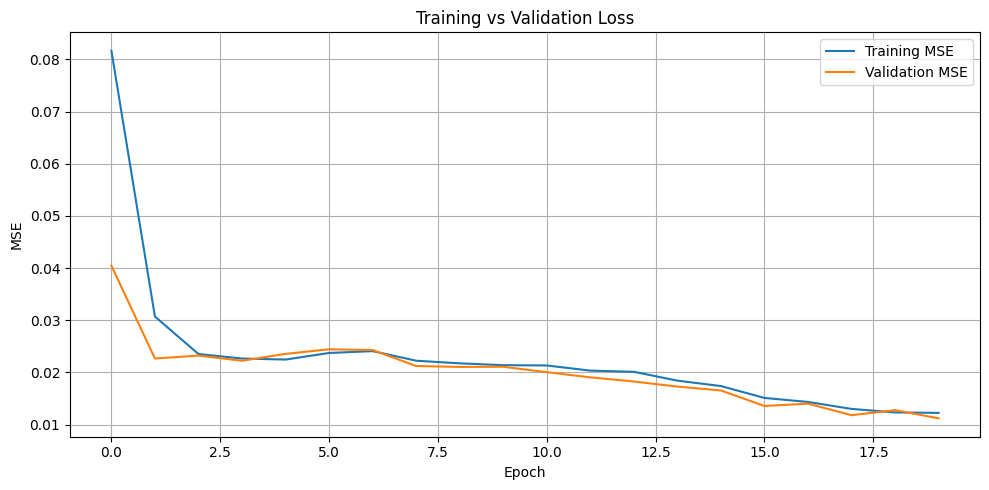

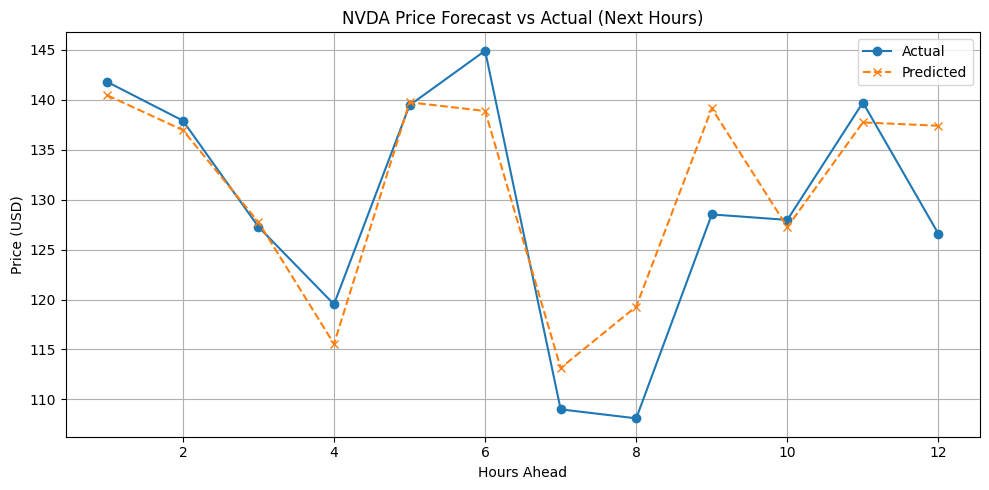

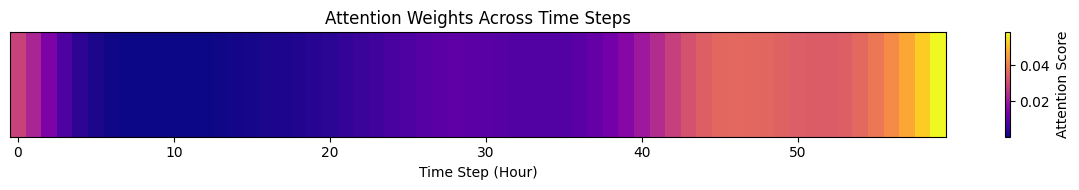

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === 1. Dataset: NVDA Hourly Series ===
class NVDAHourlyDataset(Dataset):
    def __init__(self, ticker='NVDA', period='1y', interval='1h', window_size=60, forecast_steps=12):
        df = yf.download(ticker, period=period, interval=interval)['Close'].dropna()
        prices = df.values.reshape(-1,1)
        self.scaler = MinMaxScaler()
        scaled = self.scaler.fit_transform(prices)

        sequences, targets = [], []
        for i in range(len(scaled) - window_size - forecast_steps + 1):
            sequences.append(scaled[i:i+window_size, 0])
            targets.append(scaled[i+window_size+forecast_steps-1, 0])
        self.X = torch.tensor(np.array(sequences, dtype=np.float32)).unsqueeze(-1)  # [N, window, 1]
        self.y = torch.tensor(np.array(targets, dtype=np.float32))                # [N]

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# === 2. Model: LSTM + Attention ===
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.score = nn.Linear(hidden_dim, 1)
    def forward(self, encoder_outputs):
        # encoder_outputs: [batch, seq_len, hidden]
        raw_scores = self.score(encoder_outputs).squeeze(-1)    # [batch, seq_len]
        attn_weights = torch.softmax(raw_scores, dim=1)        # [batch, seq_len]
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)  # [batch, hidden]
        return context, attn_weights

class LSTMAttnModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.attn = AttentionLayer(hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, window, input_dim]
        enc_out, _ = self.lstm(x)                    # [batch, window, hidden]
        context, weights = self.attn(enc_out)        # [batch, hidden], [batch, window]
        prediction = self.out(context).squeeze(-1)   # [batch]
        return prediction, weights

# === 3. Training & Validation Functions ===
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds, _ = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss, all_preds, all_targets, all_weights = 0.0, [], [], []
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        preds, weights = model(X_batch)
        total_loss += loss_fn(preds, y_batch).item() * X_batch.size(0)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())
        all_weights.append(weights.cpu().numpy())
    return (total_loss / len(loader.dataset),
            np.concatenate(all_preds),
            np.concatenate(all_targets),
            np.concatenate(all_weights))

# === 4. Experiment Setup ===
if __name__ == '__main__':
    # Configuration
    window_size = 60
    forecast_steps = 12
    batch_size = 32
    num_epochs = 20
    learning_rate = 1e-3
    train_ratio = 0.8

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Prepare dataset and loaders
    dataset = NVDAHourlyDataset(window_size=window_size, forecast_steps=forecast_steps)
    n_train = int(len(dataset) * train_ratio)
    n_val = len(dataset) - n_train
    train_set, val_set = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size)

    # Initialize model, loss, optimizer
    model = LSTMAttnModel(input_dim=1, hidden_dim=64, num_layers=2).to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    train_losses, val_losses = [], []
    for epoch in range(1, num_epochs+1):
        tr_loss = train(model, train_loader, loss_fn, optimizer, device)
        val_loss, _, _, _ = validate(model, val_loader, loss_fn, device)
        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch}: Train MSE={tr_loss:.4f}, Val MSE={val_loss:.4f}")

    # Final Evaluation
    final_loss, preds, targets, attn_weights = validate(model, val_loader, loss_fn, device)
    print(f"Final Validation MSE: {final_loss:.4f}")

    # === 5. Visualization ===
    # 5.1: Loss Curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training MSE')
    plt.plot(val_losses, label='Validation MSE')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5.2: Forecast vs Actual
    X_sample, y_sample = next(iter(val_loader))
    preds_sample, _ = model(X_sample.to(device))
    preds_vals = preds_sample.cpu().detach().numpy()
    actual_vals = y_sample.numpy()
    preds_orig = dataset.scaler.inverse_transform(preds_vals.reshape(-1,1)).flatten()
    actual_orig = dataset.scaler.inverse_transform(actual_vals.reshape(-1,1)).flatten()
    hours = np.arange(1, forecast_steps+1)

    plt.figure(figsize=(10,5))
    plt.plot(hours, actual_orig[:forecast_steps], marker='o', linestyle='-', label='Actual')
    plt.plot(hours, preds_orig[:forecast_steps], marker='x', linestyle='--', label='Predicted')
    plt.title('NVDA Price Forecast vs Actual (Next Hours)')
    plt.xlabel('Hours Ahead')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5.3: Attention Heatmap
    sample_weights = attn_weights[0]  # [window_size]
    plt.figure(figsize=(12,2))
    plt.imshow(sample_weights[None, :], aspect='auto', cmap='plasma')
    plt.title('Attention Weights Across Time Steps')
    plt.xlabel('Time Step (Hour)')
    plt.yticks([])
    plt.colorbar(label='Attention Score')
    plt.tight_layout()
    plt.show()


1. **Кривые обучения и валидации**
   - Модель быстро снижает ошибку за первые 5–10 эпох и стабильно улучшается на протяжении всего обучения.
   - Почти совпадающие кривые Train и Val свидетельствуют об отсутствии переобучения.

2. **Прогноз vs реальные цены**
   - Модель точно улавливает общий тренд, но «усредняет» резкие колебания, запаздывая при пиках.
   - Амплитуда прогнозов ниже истинной, что говорит о недостаточной реакции на экстремальные движения.

3. **Распределение внимания**
   - Наибольшее внимание уделяется последним 10–20 временным шагам, что логично для ближайших прогнозов.
   - Умеренное внимание к первым шагам может объясняться влиянием начальных трендовых разгонов или «горячего старта» внутри окна, когда модель фиксирует исходное направление движения.